# GeoCert : Binary MNIST Example
In this example, we'll train a neural network to distinguish between 1s and 7s and run GeoCert on it

In [1]:
# =====================
# Imports
# =====================
import sys
sys.path.append('..')
sys.path.append('../mister_ed') # library for adversarial examples

from geocert import GeoCert
from plnn import PLNN
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import mnist.mnist_loader as  ml 


# Step 1: Train a model
What follows is a block to 
1. Load MNIST 1's and 7's 
2. Define some boilerplate training code and standard regularizers
3. Try to load a pretrained model. If no such model exists, train a model and save it so we can load it next time

In [2]:
# Load valset 
valset = ml.load_single_digits('val', [1, 7], batch_size=16, shuffle=False)        

In [3]:
##################################################################################
#                                                                                #
#                       Network Model + Data Loading                             #
#                                                                                #
##################################################################################

# Define functions to train and evaluate a network 

def l1_loss(net):
    return sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])

def l2_loss(net):
    return sum([_.norm(p=2) for _ in net.parameters() if _.dim() > 1])
  
    
def train(net, trainset, num_epochs):
    opt = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0)
    for epoch in range(num_epochs):
        err_acc = 0
        err_count = 0
        for data, labels in trainset:
            output = net(Variable(data.view(-1, 784)))
            l = nn.CrossEntropyLoss()(output, Variable(labels)).view([1])
            l1_scale = torch.Tensor([1e-3]) # L1 regularization for speed
            l += l1_scale * l1_loss(net).view([1])
            
            err_acc += (output.max(1)[1].data != labels).float().mean() 
            err_count += 1
            opt.zero_grad() 
            (l).backward() 
            opt.step() 
        print("(%02d) error:" % epoch, err_acc / err_count)
            
        
def test_acc(net, valset):
    err_acc = 0 
    err_count = 0 
    for data, labels in valset:
        n = data.shape[0]
        output = net(Variable(data.view(-1, 784)))
        err_acc += (output.max(1)[1].data != labels).float().mean() * n
        err_count += n
        
    print("Accuracy of: %.03f" % (1 - (err_acc / err_count).item()))

In [4]:
NETWORK_NAME = '17_mnist_small.pkl'
MNIST_DIM = 784
layer_sizes = [MNIST_DIM, 10, 50, 10, 2]

try: 
    network = pickle.load(open(NETWORK_NAME, 'rb'))
    net = network.net
    print("Loaded pretrained network")
except:
    print("Training a new network")
    trainset = ml.load_single_digits('train', [1, 7], batch_size=16, shuffle=False)  
    network = PLNN([MNIST_DIM, 10, 50, 10, 2])
    net = network.net
    train(net, trainset, 10)
    pickle.dump(network, open(NETWORK_NAME, 'wb'))
    
test_acc(net, valset)    

Training a new network
[784, 10, 50, 10, 2]
(00) error: tensor(0.0305)
(01) error: tensor(0.0076)
(02) error: tensor(0.0064)
(03) error: tensor(0.0054)
(04) error: tensor(0.0052)
(05) error: tensor(0.0052)
(06) error: tensor(0.0047)
(07) error: tensor(0.0043)
(08) error: tensor(0.0043)
(09) error: tensor(0.0040)
Accuracy of: 0.992


# Step 2: Run GeoCert 
We'll now demonstrate basic GeoCert usage...

In [5]:
# First make the GeoCert object 
geo = GeoCert(network, hyperbox_bounds=(0.0, 1.0),
                      verbose=True, neuron_bounds='ia')

In [6]:
# And pick an example image 
example_image = valset[0][0][0]


In [7]:
# And then run geocert 
example_output = geo.run(example_image, compute_upper_bound=True, 
                             lp_norm='l_inf', problem_type='min_dist')
print(example_output)

Starting upper bound computation
Upper bound of 0.48637357354164124 in 5.75 seconds
---Initial Polytope---
Academic license - for non-commercial use only
(p0) Popped: 0.109737  | 0.486374
(p0) Popped: 0.119779  | 0.486374
(p0) Popped: 0.160164  | 0.486374
(p0) Popped: 0.164347  | 0.486374
(p0) Popped: 0.164703  | 0.486374
(p0) Popped: 0.165997  | 0.486374
(p0) Popped: 0.175892  | 0.486374
-------------------- DOMAIN UPDATE | L_inf 0.251913 | L_2 5.462510
(p0) Popped: 0.180657  | 0.251913
(p0) Popped: 0.184537  | 0.251913
(p0) Popped: 0.198900  | 0.251913
(p0) Popped: 0.203945  | 0.251913
(p0) Popped: 0.204625  | 0.251913
(p0) Popped: 0.205135  | 0.251913
(p0) Popped: 0.212172  | 0.251913
(p0) Popped: 0.213016  | 0.251913
(p0) Popped: 0.213419  | 0.251913
(p0) Popped: 0.213896  | 0.251913
(p0) Popped: 0.216059  | 0.251913
(p0) Popped: 0.217895  | 0.251913
(p0) Popped: 0.226287  | 0.251913
(p0) Popped: 0.236035  | 0.251913
GeoCert Return Object
	Problem Type: min_dist
	Status: SUCCESS
	R

In [8]:
# The return object can be interacted upon like ...
best_adv_ex = torch.Tensor(example_output.best_ex)
print("Decision bound value: ", network(best_adv_ex))



Decision bound value:  tensor([[0.1439, 0.1439]], grad_fn=<AddmmBackward>)


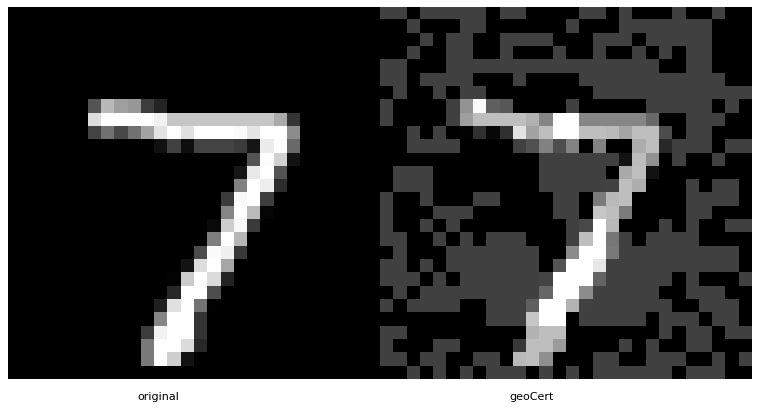

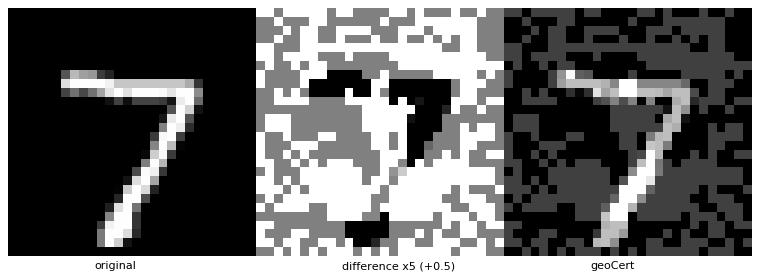

In [9]:
# And there's an easy shorthand to display these images: 
example_output.display_images(include_diffs=False) 
example_output.display_images(include_diffs=True) # Easy way to show diffs between original and adv. ex


In [11]:
# And we can also run the decision problem...
example_2 = valset[0][0][1]
example_2_output = geo.run(example_2, lp_norm='l_2', problem_type='decision_problem', 
                               decision_radius=4.0)
print(example_2_output)
# Recall that 'SUCCESS' status means an adversarial example DOES exist w/in the radius

---Initial Polytope---
(p0) Popped: 0.015449  | 4.000000
(p0) Popped: 0.016587  | 4.000000
(p0) Popped: 1.286739  | 4.000000
(p0) Popped: 1.313097  | 4.000000
(p0) Popped: 1.363232  | 4.000000
(p0) Popped: 1.365227  | 4.000000
(p0) Popped: 1.391826  | 4.000000
(p0) Popped: 1.437648  | 4.000000
(p0) Popped: 1.963248  | 4.000000
(p0) Popped: 2.173057  | 4.000000
(p0) Popped: 2.820217  | 4.000000
(p0) Popped: 2.820216  | 4.000000
(p0) Popped: 2.820221  | 4.000000
(p0) Popped: 2.997484  | 4.000000
(p0) Popped: 3.003162  | 4.000000
(p0) Popped: 3.016613  | 4.000000
(p0) Popped: 3.017497  | 4.000000
(p0) Popped: 3.024027  | 4.000000
(p0) Popped: 3.036220  | 4.000000
(p0) Popped: 3.237544  | 4.000000
(p0) Popped: 3.833163  | 4.000000
GeoCert Return Object
	Problem Type: decision_problem
	Status: SUCCESS
	Radius 4.00



In [12]:
# And we can also do things like count the number of linear regions in a ball (like the entire domain...)
example_3 = valset[0][0][2]
example_3_output = geo.run(example_3, lp_norm='l_inf', problem_type='count_regions', decision_radius=1.0)

---Initial Polytope---
(p0) Popped: 0.055832  | 1.000000
(p0) Popped: 0.056154  | 1.000000
(p0) Popped: 0.133925  | 1.000000
(p0) Popped: 0.133925  | 1.000000
(p0) Popped: 0.144106  | 1.000000
(p0) Popped: 0.150180  | 1.000000
(p0) Popped: 0.150180  | 1.000000
(p0) Popped: 0.157653  | 1.000000
(p0) Popped: 0.158780  | 1.000000
(p0) Popped: 0.170858  | 1.000000
(p0) Popped: 0.175962  | 1.000000
(p0) Popped: 0.182197  | 1.000000
(p0) Popped: 0.182393  | 1.000000
(p0) Popped: 0.182714  | 1.000000
(p0) Popped: 0.184272  | 1.000000
(p0) Popped: 0.185871  | 1.000000
(p0) Popped: 0.185899  | 1.000000
(p0) Popped: 0.189254  | 1.000000
(p0) Popped: 0.189254  | 1.000000
(p0) Popped: 0.190690  | 1.000000
(p0) Popped: 0.192021  | 1.000000
(p0) Popped: 0.192021  | 1.000000
(p0) Popped: 0.194611  | 1.000000
(p0) Popped: 0.206525  | 1.000000
(p0) Popped: 0.212611  | 1.000000
(p0) Popped: 0.215649  | 1.000000
(p0) Popped: 0.216742  | 1.000000
(p0) Popped: 0.218444  | 1.000000
(p0) Popped: 0.219127  | 

In [ ]:
print(example_3_output)